# Token-Wrapped Token Delta

## Ayodeji Adeniyi 13/08/2024
Personal research into efficiency of wrapped tokens, and their market impact,  and possible other uses (i.e., arbitrage oppurtunities, trading positions, and cross-chain liquidity and volume).

Interests include:

Analysis and predictions of price differences, liquidity, and volume of wrapped tokens compared to their native counterparts

Outlook on possible arbitrage opportunities, identifying improvemenmts to trading positions taken during the monitored period

Outlook on the potential for wrapped tokens to become the preferred trading instrument in the bct world and the potential for positive impact on the market due to the increased cross-chain liquidity and volume they provide. Even the "wrappers" are tradeable assets that can be analysed and indexed against.

Interactive Plot Handling, and Python - Excel Dashboard curation


The research will be conducted using the following steps:
1.  Data Collection

    Price, Volume, Liquidity of tokens and wrapped versions of interest (BTC, ETH, SOL)

2.  Data Cleaning

    Remove missing values, duplicates, and outliers for time series split (prophet will handle these automatically)

    Compute the returns, volatility, and other metrics for the tokens and their wrapped versions

    Normalize the data to make it comparable

    Create features for machine learning models, such as moving averages, RSI, MACD, Bollinger Bands, and other technical indicators Display the data in a table for analysis

3.  Data Analysis

    Compare the price, volume, and liquidity of the tokens and their wrapped versions

    Conduct time series analysis to identify trends, seasonality, and cycles

    Conduct correlation analysis to identify relationships between the tokens and their wrapped versions

    Conduct regression analysis to identify the impact of the tokens on their wrapped versions

    Conduct sentiment analysis to identify the impact of news and events on the tokens and their wrapped versions

    Conduct ARIMA models on price, volume, and liquidity to predict future values

    Splite time series data into training and testing sets using time series split method, and monte carlo cross validation separately

    Train machine learning models on the training data to predict future values

    Evaluate the models using the testing data to identify the best model

4.  Data Visualization

    Create interactive charts and graphs to visualize the data using matplotlib, plotly and dash

5.  Conclusion

    Summarize the findings and provide recommendations based on the analysis

    Identify the limitations of the research and propose future work

    Provide the data, code, and results for reproducibility

The data will be collected from the following sources:
Coinbase and Kraken.  The data will be collected using the APIs provided by the exchanges.  The data will be collected in real-time and stored in a database for analysis.


In [2]:
# Imports
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# API requests
import requests

# Time series analysis
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kendalltau
from datetime import datetime, timedelta

# Time zone handling
import pytz



Kraken API pairs all assetpairs url
https://api.kraken.com/0/public/AssetPairs

Coinbase API pairs all assetpairs url https://api.pro.coinbase.com/products

In [3]:
BASE_URLC = 'https://api.pro.coinbase.com' # Coinbase API endpoint
BASE_URLB = 'https://api.binance.com' # Binance API endpoint

In [4]:
# Define the headers for the API requests
headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "CB-ACCESS-KEY": "MY_API_KEY"
}

# Define the GBP/USD conversion rate
GBP_USD_RATE = 1.38  # Example conversion rate - update later to fetch from bloomberg website

# Function to fetch historical data from Coinbase
def fetch_hist_data(product_id, start, end, interval):
    url = f"{BASE_URLC}/products/{product_id}/candles"
    params = {
        "start": start,
        "end": end,
        "granularity": interval  # 86400 corresponds to daily candles
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data:
        print(f"No data fetched for {product_id}")
        return pd.DataFrame()
    return pd.DataFrame(data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])

# Define the time ranges (1 month)
end = datetime.utcnow()
start = end - timedelta(days=30)

# Fetch the data for SOL-USD and MSOL-USD for the last month
sol_data = fetch_hist_data("SOL-USD", start.isoformat(), end.isoformat(), 86400)
msol_data = fetch_hist_data("MSOL-USD", start.isoformat(), end.isoformat(), 86400)

C:\Users\ayode\AppData\Local\Temp\ipykernel_31508\2105153801.py:27: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow()


Failed to fetch data for MNDE-GBP.


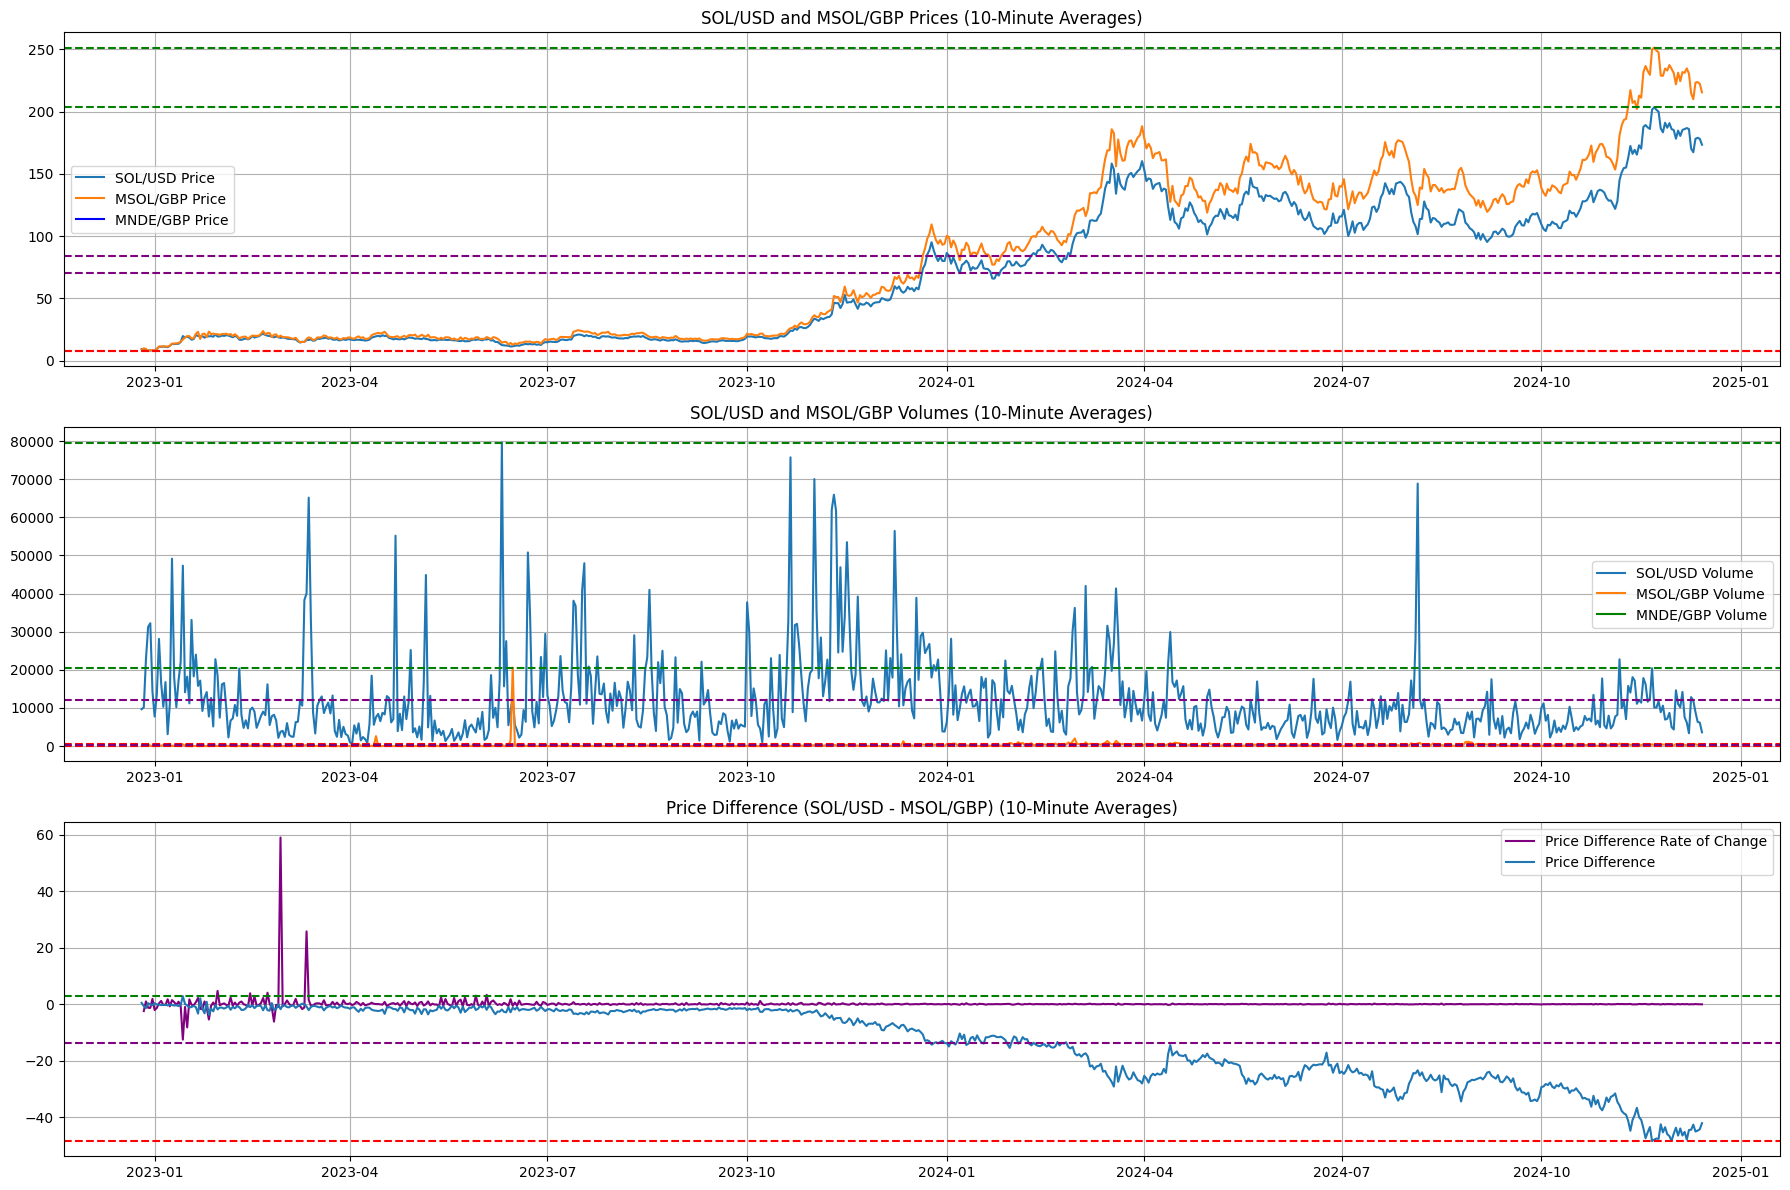

In [9]:

# Function to fetch data from Kraken API
def fetch_kraken_data(pair):
    url = f'https://api.kraken.com/0/public/OHLC?pair={pair}&interval=1440'
    response = requests.get(url)
    data = response.json()['result'][pair]
    df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df[['time', 'close', 'volume']]

# Fetch SOL/USD and MSOL/USD data
solusd_data = fetch_kraken_data('SOLGBP')
msolusd_data = fetch_kraken_data('MSOLUSD')


# Conversion rates
usd_to_gbp = 0.7568  # Bloomberg conversion rate

# Fetch the conversion rate from USD to GBP
def fetch_conversion_rate():
    url = "https://api.exchangerate-api.com/v4/latest/USD"
    response = requests.get(url)
    rates = response.json().get("rates", {})
    return rates.get("GBP", usd_to_gbp)  # Fallback conversion rate

usd_to_gbp = fetch_conversion_rate()

# Convert MSOL/USD to MSOL/GBP
msolusd_data['close'] = msolusd_data['close'].astype(float).round(2) * usd_to_gbp
msolusd_data['volume'] = msolusd_data['volume'].astype(float).round(2) * usd_to_gbp

# Merge datasets on time
merged_data = pd.merge(solusd_data, msolusd_data, on='time', suffixes=('_sol', '_msol'))

# Calculate differences
merged_data['price_diff'] = merged_data['close_sol'].astype(float) - merged_data['close_msol'].astype(float)
merged_data['volume_diff'] = merged_data['volume_sol'].astype(float) - merged_data['volume_msol'].astype(float)

# Ensure all columns are numeric (handling errors)
numeric_columns = ['close_sol', 'close_msol', 'volume_sol', 'volume_msol', 'price_diff', 'volume_diff']
merged_data[numeric_columns] = merged_data[numeric_columns].apply(pd.to_numeric, errors='coerce')


resampled_data = merged_data#for normal data

# Get price for marinade the token using coinbase API in GBP
def fetch_hist_data(product_id, start, end, interval):
    url = f"{BASE_URLC}/products/{product_id}/candles"
    params = {
        "start": start,
        "end": end,
        "granularity": interval  # 86400 corresponds to daily candles
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data:
        print(f"No data fetched for {product_id}")
        return pd.DataFrame()
    return pd.DataFrame(data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])

# Define the time ranges (1 day)
end = datetime.now(pytz.utc)
start = end - timedelta(days=1)

# Fetch marinade token price MNDE
mnde_data = fetch_hist_data("MNDE-USD", start.isoformat(), end.isoformat(), 86400)
mnde_data['close'] = mnde_data['close'] * usd_to_gbp


# Check if data is fetched correctly
if mnde_data.empty:
    print("Failed to fetch data for MNDE-GBP.")
else:
    # Convert 'time' column to datetime
    mnde_data['time'] = pd.to_datetime(mnde_data['time'], unit='s')

    # Plot the data in subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Subplot 1: SOL vs mSOL Prices
    axs[0].plot(mnde_data['time'], mnde_data['close'], label='MNDE Price (GBP)', color='blue')
    axs[0].set_title('MNDE Prices Over the Last Day')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price (GBP)')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Price Difference
    axs[1].plot(mnde_data['time'], mnde_data['volume'], label='Volume', color='green')
    axs[1].set_title('MNDE Volume Over the Last Day')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Volume')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


# Calculate rate of change for price difference
resampled_data['price_diff_roc'] = resampled_data['price_diff'].pct_change()


# Fetch the data for SOL-USD and MSOL-USD for the last month
sol_data = fetch_hist_data("SOL-USD", start.isoformat(), end.isoformat(), 86400)

# Plot the resampled data and differences
plt.figure(figsize=(18, 12))

# Plot 1: Prices
plt.subplot(3, 1, 1)
plt.plot(resampled_data['time'], resampled_data['close_sol'], label='SOL/USD Price')
plt.plot(resampled_data['time'], resampled_data['close_msol'], label='MSOL/GBP Price')
plt.title('SOL/USD and MSOL/GBP Prices (10-Minute Averages)')
plt.legend()
plt.grid(True)

#Superimpose MNDE price on the plot
plt.plot(mnde_data['time'], mnde_data['close'], label='MNDE/GBP Price', color='blue')
plt.legend()


#add dashed lines showing high (green) and low (red) prices and averages (purple) with labels
plt.axhline(y=resampled_data['close_sol'].max(), color='g', linestyle='--', label='SOL/USD High')
plt.axhline(y=resampled_data['close_sol'].min(), color='r', linestyle='--', label='SOL/USD Low')
plt.axhline(y=resampled_data['close_msol'].max(), color='g', linestyle='--', label='MSOL/GBP High')
plt.axhline(y=resampled_data['close_msol'].min(), color='r', linestyle='--', label='MSOL/GBP Low')
plt.axhline(y=resampled_data['close_sol'].mean(), color='purple', linestyle='--', label='SOL/USD Average')
plt.axhline(y=resampled_data['close_msol'].mean(), color='purple', linestyle='--', label='MSOL/GBP Average')

# Plot 2: Volumes
plt.subplot(3, 1, 2)
plt.plot(resampled_data['time'], resampled_data['volume_sol'], label='SOL/USD Volume')
plt.plot(resampled_data['time'], resampled_data['volume_msol'], label='MSOL/GBP Volume')
plt.title('SOL/USD and MSOL/GBP Volumes (10-Minute Averages)')
plt.legend()
plt.grid(True)

#Superimpose MNDE volume on the plot
plt.plot(mnde_data['time'], mnde_data['volume'], label='MNDE/GBP Volume', color='green')
plt.legend()

#add dashed lines showing high (green) and low (red) volumes and averages (purple) with labels
plt.axhline(y=resampled_data['volume_sol'].max(), color='g', linestyle='--', label='SOL/USD High')
plt.axhline(y=resampled_data['volume_sol'].min(), color='r', linestyle='--', label='SOL/USD Low')
plt.axhline(y=resampled_data['volume_msol'].max(), color='g', linestyle='--', label='MSOL/GBP High')
plt.axhline(y=resampled_data['volume_msol'].min(), color='r', linestyle='--', label='MSOL/GBP Low')
plt.axhline(y=resampled_data['volume_sol'].mean(), color='purple', linestyle='--', label='SOL/USD Average')
plt.axhline(y=resampled_data['volume_msol'].mean(), color='purple', linestyle='--', label='MSOL/GBP Average')


# Plot 3: Price Difference
plt.subplot(3, 1, 3)
plt.plot(resampled_data['time'], resampled_data['price_diff_roc'], label='Price Difference Rate of Change', color='purple')
plt.plot(resampled_data['time'], resampled_data['price_diff'], label='Price Difference')
plt.title('Price Difference (SOL/USD - MSOL/GBP) (10-Minute Averages)')
plt.legend()
plt.grid(True)

#add dashed lines showing high (green) and low (red) price differences and averages (purple) with labels
plt.axhline(y=resampled_data['price_diff'].max(), color='g', linestyle='--', label='Price Difference High')
plt.axhline(y=resampled_data['price_diff'].min(), color='r', linestyle='--', label='Price Difference Low')
plt.axhline(y=resampled_data['price_diff'].mean(), color='purple', linestyle='--', label='Price Difference Average')

plt.tight_layout()
plt.show()






Pearson Correlation between price and volume differences (10-Minute Averages): 0.18477848880814163
ADF Statistic (10-Minute Averages): 0.09929692888093533, p-value: 0.966013059364305
Kendall tau (10-Minute Averages): -0.813776850564055, p-value: 3.6023037325020935e-234


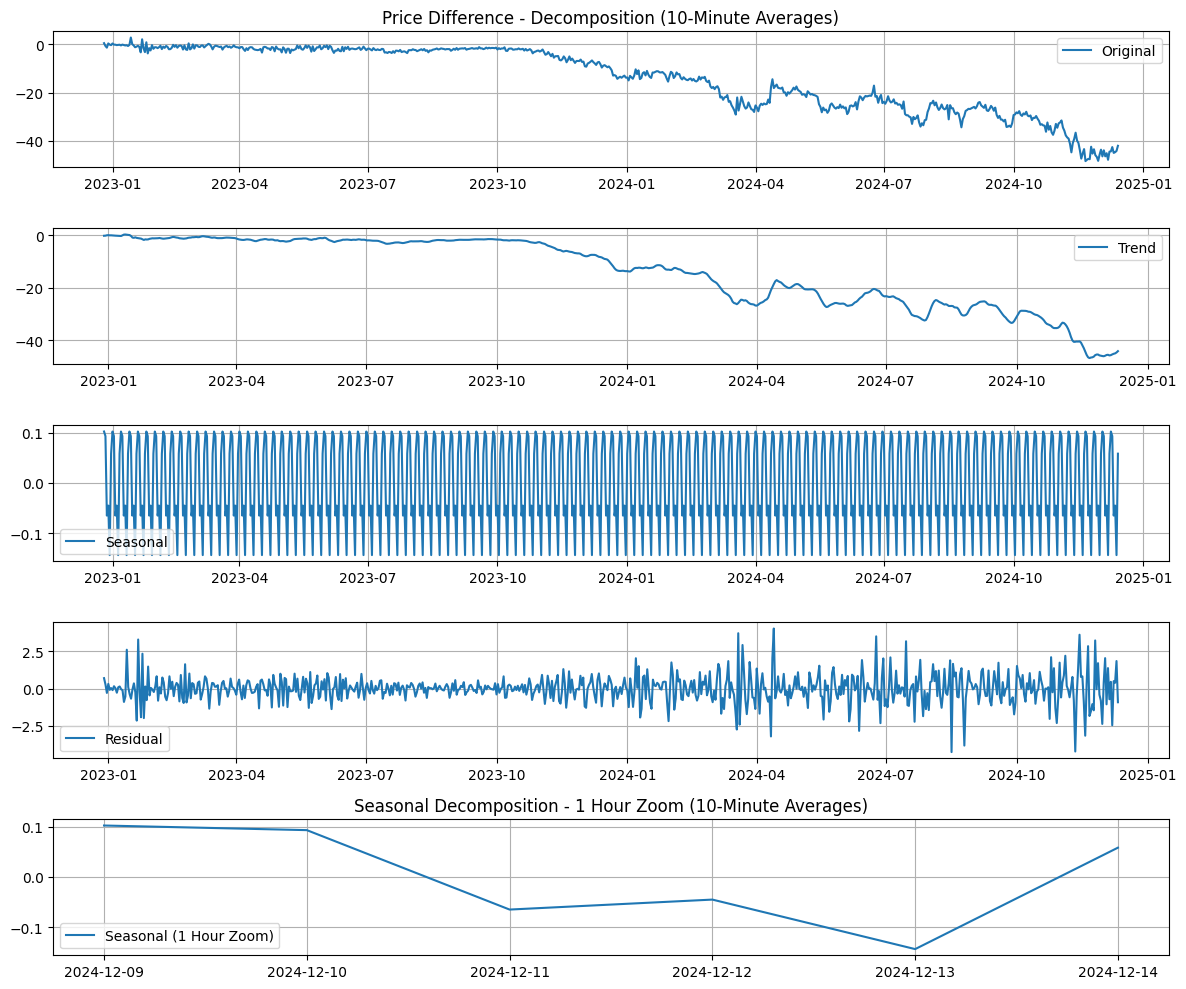

ValueError: Length of values (719) does not match length of index (720)

In [10]:
# Pearson Correlation on resampled data
price_vol_corr = resampled_data['price_diff'].corr(resampled_data['volume_diff'])
print(f'Pearson Correlation between price and volume differences (10-Minute Averages): {price_vol_corr}')

# ADF Test for Price Difference on resampled data
adf_result = adfuller(resampled_data['price_diff'].dropna())
print(f'ADF Statistic (10-Minute Averages): {adf_result[0]}, p-value: {adf_result[1]}')

# Mann-Kendall Trend Test for Price Difference on resampled data
tau, p_value = kendalltau(range(len(resampled_data['price_diff'])), resampled_data['price_diff'].dropna())
print(f'Kendall tau (10-Minute Averages): {tau}, p-value: {p_value}')

# Time Series Decomposition on resampled data
decomposition = seasonal_decompose(resampled_data['price_diff'].dropna(), model='additive', period=6)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition of resampled data
plt.figure(figsize=(12, 10))
plt.subplot(5, 1, 1)
plt.plot(resampled_data['time'], resampled_data['price_diff'], label='Original')
plt.title('Price Difference - Decomposition (10-Minute Averages)')
plt.legend()
plt.grid(True)

plt.subplot(5, 1, 2)
plt.plot(resampled_data['time'], trend, label='Trend')
plt.legend()
plt.grid(True)

plt.subplot(5, 1, 3)
plt.plot(resampled_data['time'], seasonal, label='Seasonal')
plt.legend()
plt.grid(True)

plt.subplot(5, 1, 4)
plt.plot(resampled_data['time'], residual, label='Residual')
plt.legend()
plt.grid(True)

# One-hour zoom on the seasonal decomposition
one_hour_data = resampled_data.tail(6)  # Assuming 10-minute intervals, 6 data points for 1 hour
one_hour_seasonal = seasonal.tail(6)
plt.subplot(5, 1, 5)
plt.plot(one_hour_data['time'], one_hour_seasonal, label='Seasonal (1 Hour Zoom)')
plt.title('Seasonal Decomposition - 1 Hour Zoom (10-Minute Averages)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Linear Regression for trend detection on resampled data
x = np.array(range(len(resampled_data.dropna()))).reshape(-1, 1)
y = resampled_data['price_diff'].dropna().values

# Check and trim if necessary
if len(x) > len(y):
    x = x[:len(y)]
elif len(y) > len(x):
    y = y[:len(x)]

model = LinearRegression().fit(x, y)
resampled_data['price_diff_trend'] = model.predict(x)

# Plot Linear Regression Trend on resampled data
plt.figure(figsize=(12, 6))
plt.plot(resampled_data['time'], resampled_data['price_diff'], label='Price Difference (10-Minute Averages)')
plt.plot(resampled_data['time'], resampled_data['price_diff_trend'], label='Linear Trend', linestyle='--')
plt.title('Price Difference with Linear Trend (10-Minute Averages)')
plt.legend()
plt.grid(True)
plt.show()


# Resample the data into 10-minute bins and calculate moving averages
resampled_data = merged_data.resample('10T', on='time').mean().reset_index()

# Calculate 10-minute moving averages
resampled_data['close_sol_ma'] = resampled_data['close_sol'].rolling(window=6).mean()
resampled_data['close_msol_ma'] = resampled_data['close_msol'].rolling(window=6).mean()
resampled_data['volume_sol_ma'] = resampled_data['volume_sol'].rolling(window=6).mean()
resampled_data['volume_msol_ma'] = resampled_data['volume_msol'].rolling(window=6).mean()

# Calculate price and volume differences
resampled_data['price_diff'] = resampled_data['close_sol'] - resampled_data['close_msol']
resampled_data['volume_diff'] = resampled_data['volume_sol'] - resampled_data['volume_msol']

# Calculate moving averages for differences
resampled_data['price_diff_ma'] = resampled_data['price_diff'].rolling(window=6).mean()
resampled_data['volume_diff_ma'] = resampled_data['volume_diff'].rolling(window=6).mean()

# Calculate rate of change for price difference
resampled_data['price_diff_roc'] = resampled_data['price_diff'].pct_change()

# Plot the resampled data and moving averages superimposed as a black line
plt.figure(figsize=(18, 12))

# Plot 1: Prices
plt.subplot(4, 1, 1)
plt.plot(resampled_data['time'], resampled_data['close_sol'], label='SOL/USD Price')
plt.plot(resampled_data['time'], resampled_data['close_msol'], label='MSOL/GBP Price')
plt.plot(resampled_data['time'], resampled_data['close_sol_ma'], label='SOL/USD Price MA', color='black')
plt.plot(resampled_data['time'], resampled_data['close_msol_ma'], label='MSOL/GBP Price MA', color='black')
plt.title('SOL/USD and MSOL/GBP Prices (10-Minute Averages)')
plt.legend()
plt.grid(True)

# Plot 2: Volumes
plt.subplot(4, 1, 2)
plt.plot(resampled_data['time'], resampled_data['volume_sol'], label='SOL/USD Volume')
plt.plot(resampled_data['time'], resampled_data['volume_msol'], label='MSOL/GBP Volume')
plt.plot(resampled_data['time'], resampled_data['volume_sol_ma'], label='SOL/USD Volume MA', color='black')
plt.plot(resampled_data['time'], resampled_data['volume_msol_ma'], label='MSOL/GBP Volume MA', color='black')
plt.title('SOL/USD and MSOL/GBP Volumes (10-Minute Averages)')
plt.legend()
plt.grid(True)

# Plot 3: Price Difference
plt.subplot(4, 1, 3)#calculate rate of change for price difference
plt.plot(resampled_data['time'], resampled_data['price_diff'], label='Price Difference')
plt.plot(resampled_data['time'], resampled_data['price_diff_ma'], label='Price Difference MA', color='black')
#superimpose rate of change on price difference plot
plt.plot(resampled_data['time'], resampled_data['price_diff_roc'], label='Price Difference Rate of Change', color='purple')
plt.title('Price Difference (SOL/USD - MSOL/GBP) (10-Minute Averages)')
plt.legend()
plt.grid(True)


# Pearson Correlation on resampled data
price_vol_corr = resampled_data['price_diff'].corr(resampled_data['volume_diff'])
print(f'Pearson Correlation between price and volume differences (10-Minute Averages): {price_vol_corr}')

# ADF Test for Price Difference on resampled data
adf_result = adfuller(resampled_data['price_diff'].dropna())
print(f'ADF Statistic (10-Minute Averages): {adf_result[0]}, p-value: {adf_result[1]}')

In [6]:
url = "https://api.kraken.com/0/public/Depth?pair=SOLGBP"

payload = {}
headers = {
  'Accept': 'application/json'
}

response = requests.request("GET", url, headers=headers, data=payload)

print(response.text)

{"error":[],"result":{"SOLGBP":{"asks":[["172.85000","0.338",1734217674],["172.86000","45.835",1734217675],["172.88000","8.540",1734217670],["172.91000","8.503",1734217670],["172.92000","10.231",1734217674],["172.93000","4.947",1734217674],["172.94000","1.996",1734217672],["172.95000","29.452",1734217675],["172.96000","10.460",1734217649],["173.02000","72.231",1734217673],["173.03000","91.711",1734217671],["173.04000","22.895",1734217670],["173.05000","2.720",1734217657],["173.06000","12.865",1734217675],["173.08000","30.460",1734217673],["173.12000","26.790",1734217667],["173.17000","25.850",1734217672],["173.34000","45.708",1734217642],["173.35000","0.043",1734216899],["173.80000","113.966",1734217642],["173.82000","24.249",1734216223],["174.15000","0.043",1734206648],["174.23000","16.648",1734216238],["174.39000","8.122",1734216223],["174.46000","220.194",1734217179],["174.47000","227.063",1734217127],["174.55000","7.784",1734216324],["174.77000","3.811",1734217499],["174.96000","0.